<a href="https://colab.research.google.com/github/VishnuPrem/cnn_action_recognition/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from datetime import datetime
import pytz

from google.colab import drive
!ls "/content/gdrive/My Drive/CIS 519 project"
drive.mount('/content/gdrive') #mounting onto Google drive 


ls: cannot access '/content/gdrive/My Drive/CIS 519 project': No such file or directory
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

class VidDataset(Dataset):
  def __init__(self, X, y):
    self.len = len(X)
    self.X = torch.FloatTensor(X).cuda()
    self.y = torch.FloatTensor(y).cuda()
  
  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  

def load_datasets():

  X_train = np.load("/content/gdrive/My Drive/CIS 519 project/Model/OpticalStack/x_train.npy").astype(float)
  y_train = np.load("/content/gdrive/My Drive/CIS 519 project/Model/OpticalStack/y_train.npy")
  X_valid = np.load("/content/gdrive/My Drive/CIS 519 project/Model/OpticalStack/x_valid.npy").astype(float)
  y_valid = np.load("/content/gdrive/My Drive/CIS 519 project/Model/OpticalStack/y_valid.npy")
  X_test = np.load("/content/gdrive/My Drive/CIS 519 project/Model/OpticalStack/x_test.npy").astype(float)
  y_test = np.load("/content/gdrive/My Drive/CIS 519 project/Model/OpticalStack/y_test.npy")
  
  X_train = np.transpose(X_train,(0,3,1,2))
  X_valid = np.transpose(X_valid,(0,3,1,2))
  X_test = np.transpose(X_test,(0,3,1,2))

  y_train = np.squeeze(y_train)
  y_valid = np.squeeze(y_valid)
  y_test = np.squeeze(y_test)

  train_data = VidDataset(X_train, y_train)
  valid_data = VidDataset(X_valid, y_valid)
  test_data = VidDataset(X_test, y_test)
  
  return train_data, valid_data, test_data


In [0]:
class DualStreamConv(torch.nn.Module):
  def __init__(self):

    super().__init__()
    self.im_conv1 = torch.nn.Conv2d(in_channels=1,
                                 out_channels=7,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)

    self.im_pool = nn.MaxPool2d(2, 2)
    self.im_conv2 = torch.nn.Conv2d(in_channels=7,
                                 out_channels=16,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)
    
    self.im_fc1 = torch.nn.Linear(35344, 1300)
    self.im_fc2 = torch.nn.Linear(1300, 72)

    self.of_conv1 = torch.nn.Conv2d(in_channels=1,
                                 out_channels=7,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)
    
    self.of_pool = nn.MaxPool2d(2, 2)
    self.of_conv2 = torch.nn.Conv2d(in_channels=7,
                                 out_channels=16,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)
    
    self.of_fc1 = torch.nn.Linear(35344, 1300)
    self.of_fc2 = torch.nn.Linear(1300, 72)

    self.fc1 = torch.nn.Linear(144, 1)
    #self.fc2 = torch.nn.Linear(50, 1)


  def forward(self, X):
    
    batch_size = X.size(0)
    X_im = X[:,0,:,:]

    X_im = X_im.view(batch_size,1,100,100)

    X_im = self.im_conv1(X_im)
    X_im = self.im_pool(X_im)
    X_im = self.im_conv2(X_im)
    X_im = F.relu(X_im)
    X_im = X_im.view(-1,35344)
    X_im = F.relu(self.im_fc1(X_im))
    X_im = F.relu(self.im_fc2(X_im))

    X_of = X[:,1,:,:]

    X_of = X_of.view(batch_size,1,100,100)

    X_of = self.of_conv1(X_of)
    X_of = self.of_pool(X_of)
    X_of = self.of_conv2(X_of)
    X_of = F.relu(X_of)
    X_of = X_of.view(-1,35344)
    X_of = F.relu(self.of_fc1(X_of))
    X_of = F.relu(self.of_fc2(X_of))

    X = torch.cat((X_im, X_of),1)

    X = torch.sigmoid(self.fc1(X))
    #X = torch.sigmoid(self.fc2(X))

    X = X.view(batch_size)

    return X

In [0]:
class SingleStreamConv(torch.nn.Module):
  def __init__(self):

    super().__init__()
    self.im_conv1 = torch.nn.Conv2d(in_channels=10,
                                 out_channels=7,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)

    self.im_pool = nn.MaxPool2d(2, 2)
    self.im_conv2 = torch.nn.Conv2d(in_channels=7,
                                 out_channels=16,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)
    
    self.im_fc1 = torch.nn.Linear(35344, 1300)
    self.im_fc2 = torch.nn.Linear(1300, 72)

    self.fc1 = torch.nn.Linear(72, 50)
    self.fc2 = torch.nn.Linear(50, 1)


  def forward(self, X):
    
    batch_size = X.size(0)

    X_im = X.view(batch_size,1,100,100)

    X_im = self.im_conv1(X_im)
    X_im = self.im_pool(X_im)
    X_im = self.im_conv2(X_im)
    X_im = F.relu(X_im)
    X_im = X_im.view(-1,35344)
    X_im = F.relu(self.im_fc1(X_im))
    X_im = F.relu(self.im_fc2(X_im))

    X = F.relu(self.fc1(X_im))
    X = torch.sigmoid(self.fc2(X))

    X = X.view(batch_size)

    return X

In [0]:

def find_accuracy(network, data_loader):
  
  total_loss = 0
  num_correct = 0
  num_instances = 0

  binary_cross_entropy_loss = torch.nn.BCELoss()
  
  with torch.no_grad():
    for X, y in data_loader:
      y_pred = network(X)
      loss = binary_cross_entropy_loss(y_pred, y)
      total_loss += loss
      predicted = y_pred.round()
      num_correct += (predicted == y).sum().item()
      num_instances += X.size(0)
  
  accuracy = num_correct / num_instances * 100
  average_loss = total_loss / num_instances
  return accuracy, average_loss

In [0]:

def train_model(network, train_data_loader, valid_data_loader, optimizer):

  train_losses = []
  valid_accs = []
  valid_losses = []

  binary_cross_entropy_loss = torch.nn.BCELoss()

  for epoch in range(20):
    
    total_loss = 0.0
    num_instances = 0
    
    print('Epoch number: ', epoch)

    for X, y in train_data_loader:

      optimizer.zero_grad()
      y_pred = network(X)
      loss = binary_cross_entropy_loss(y_pred, y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      num_instances += X.size(0)

    train_loss = total_loss / num_instances
    train_losses.append(train_loss)
    
    valid_acc, valid_loss = find_accuracy(network, valid_data_loader)

    valid_accs.append(valid_acc)
    valid_losses.append(valid_loss)
  
  return train_losses, valid_accs, valid_losses
  

In [0]:

def save_model(network,lr):

  tz_NY = pytz.timezone('America/New_York') 
  datetime_NY = datetime.now(tz_NY)
  curr_time = datetime_NY.strftime("_t_%H_%M")

  model_type = str(type(network))
  model_type = model_type[17:22]
  file_name = model_type+'_lr_'+str(lr)+curr_time+'.pt'
  PATH = '/content/gdrive/My Drive/CIS 519 project/Model/TrainedModel/' + file_name
  print('Saved to: ', PATH)
  torch.save(network, PATH)



In [0]:

train_data, valid_data, test_data = load_datasets()
train_data_loader = DataLoader(train_data, batch_size=1)
valid_data_loader = DataLoader(valid_data, batch_size=1)
test_data_loader = DataLoader(test_data, batch_size=1)

Epoch number:  0
Epoch number:  1
Epoch number:  2
Epoch number:  3
Epoch number:  4
Epoch number:  5
Epoch number:  6
Epoch number:  7
Epoch number:  8
Epoch number:  9
Epoch number:  10
Epoch number:  11
Epoch number:  12
Epoch number:  13
Epoch number:  14
Epoch number:  15
Epoch number:  16
Epoch number:  17
Epoch number:  18
Epoch number:  19
LR = 0.001, Valid Acc: 66.33333333333333
Saved to:  /content/gdrive/My Drive/CIS 519 project/Model/TrainedModel/DualS_lr_0.001_t_12_49.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DualStreamConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch number:  0
Epoch number:  1
Epoch number:  2
Epoch number:  3
Epoch number:  4
Epoch number:  5
Epoch number:  6
Epoch number:  7
Epoch number:  8
Epoch number:  9
Epoch number:  10
Epoch number:  11
Epoch number:  12
Epoch number:  13
Epoch number:  14
Epoch number:  15
Epoch number:  16
Epoch number:  17
Epoch number:  18
Epoch number:  19
LR = 0.01, Valid Acc: 51.0
Saved to:  /content/gdrive/My Drive/CIS 519 project/Model/TrainedModel/DualS_lr_0.01_t_12_53.pt
Epoch number:  0
Epoch number:  1
Epoch number:  2
Epoch number:  3
Epoch number:  4
Epoch number:  5
Epoch number:  6
Epoch number:  7
Epoch number:  8
Epoch number:  9
Epoch number:  10
Epoch number:  11
Epoch number:  12
Epoch number:  13
Epoch number:  14
Epoch number:  15
Epoch number:  16
Epoch number:  17
Epoch number:  18
Epoch number:  19
LR = 0.1, Valid Acc: 51.0
Saved to:  /content/gdrive/My Drive/CIS 519 project/Model/TrainedModel/DualS_lr_0.1_t_12_57.pt
Test Accuracy: 73.66666666666667


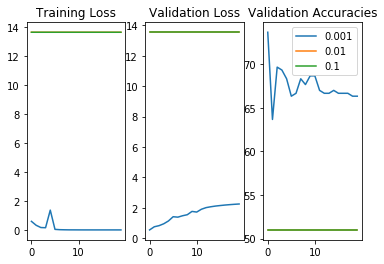

In [0]:
best_network = None
best_acc = None

_, axs = plt.subplots(1,3)
axs[0].set_title('Training Loss')
axs[1].set_title('Validation Loss')
axs[2].set_title('Validation Accuracies')

for lr in [0.001, 0.01, 0.1]:
  network = DualStreamConv()
  network.cuda()
  sgd = torch.optim.SGD(network.parameters(), lr=lr)

  train_losses, valid_accs, valid_losses = train_model(network, train_data_loader, valid_data_loader, sgd)
  
  valid_acc = valid_accs[-1]
  print(f'LR = {lr}, Valid Acc: {valid_acc}')
  
  if best_acc is None or valid_acc > best_acc:
    best_acc = valid_acc
    best_network = network
  
  axs[0].plot(train_losses, label=str(lr))
  axs[1].plot(valid_losses, label=str(lr))
  axs[2].plot(valid_accs, label=str(lr))

  save_model(network,lr)

plt.legend()

test_acc, _ = find_accuracy(best_network, test_data_loader)
print('Test Accuracy: ' + str(test_acc))
